# ノート 2: sub-SEVIR データの探求

### 目標: sub-SEVIR データをプロットしてデータに親しむ

### 背景

機械学習に使うデータをよく知っていることは大切なことです。
このノートではチュートリアルで使う sub-SEVIR データの一部をいろいろと可視化して見ていきます。
データを使いこなせていれば、どのような場合に機械学習がうまくいかなくなるかをあらかじめ予測しやすくなります。


### Step 1: インポート


In [2]:
import warnings
warnings.filterwarnings("ignore") # 不要な警告の抑止

from pprint import pprint
import sys

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# ユーティリティ関数へのパス
sys.path.insert(1, "../scripts/")

# jupyterのカスタマイズ
%config InlineBackend.figure_format = 'retina'

### Step 2: データの読み込み

ノート 1 でダウンロードしたデータは ファイル圧縮性に優れた Zarr 形式というクラウドコンピューティング使われる新しいファイル形式です。
xarray を使えば Part1 で扱った netCDF と同じ方法で読み込むことができます。

ファイルを読み込んでメタデータを出力してみましょう。


In [3]:
# engine オプションに zarr を指定する
ds_train = xr.open_dataset("../datasets/sub-sevir/sub-sevir-train.zarr", engine="zarr")

ds_train

<xarray.Dataset>
Dimensions:         (n_samples: 60000, x: 48, y: 48, n_channel: 4)
Coordinates:
    id              (n_samples) object ...
  * n_channel       (n_channel) <U5 'ir069' 'ir107' 'vil' 'vis'
  * n_samples       (n_samples) datetime64[ns] 2018-08-25T00:15:00 ... 2019-0...
Dimensions without coordinates: x, y
Data variables:
    features        (n_samples, x, y, n_channel) float32 ...
    label_1d_class  (n_samples) int8 ...
    label_1d_reg    (n_samples) int16 ...
    label_2d_class  (n_samples, x, y) int8 ...
    label_2d_reg    (n_samples, x, y) int16 ...

このデータファイルには以下の変数が含まれます。

#### 1. `features`

機械学習の入力に使う特徴量です。次元 n_channel は画像の種類を表し 水蒸気、赤外、VIL、可視の順に並んでいます。

#### 2. `label_**_**`

機械学習の出力に使うラベルです。
名前に`_1d` を含むものは 1 次元問題のラベルでノート 3 で扱う古典的機械学習法とノート 4-6 の ANN、CNN で使います。
`_2d` を含むものは 2 次元問題で使うラベルでノート 8 の U-net で使います。
`_class` は分類問題のラベル（発雷の有無）、`_reg` は回帰問題のラベル（発雷の数）を表します。

このデータセットには 60,000 枚の画像が含まれており、ニューラルネットワークの学習に使うには十分なサンプル数です。

まずは、1 つのサンプルを見てみましょう。xarray は必要なデータを取り出すメソッドがいくつか用意されています。
サンプル番号 42 のデータを取り出したい場合は、`.isel` メソッドでインデックスを指定します。


In [4]:
# n_samples 次元のインデックス42のデータにアクセス
ds_sample = ds_train.isel(n_samples=42)

ds_sample

<xarray.Dataset>
Dimensions:         (x: 48, y: 48, n_channel: 4)
Coordinates:
    id              object ...
  * n_channel       (n_channel) <U5 'ir069' 'ir107' 'vil' 'vis'
    n_samples       datetime64[ns] 2018-07-12T01:05:00
Dimensions without coordinates: x, y
Data variables:
    features        (x, y, n_channel) float32 ...
    label_1d_class  int8 ...
    label_1d_reg    int16 ...
    label_2d_class  (x, y) int8 ...
    label_2d_reg    (x, y) int16 ...

1 つのサンプルを取り出したので n_samples 次元が空になっていることがわかります。このサンプルをプロットしてみます。


In [5]:
def show_sample(ds):
    fig, axes = plt.subplots(1, 5, figsize=(10, 6))
    
    # カラーマップ
    cmaps = ["Blues", "turbo", "Spectral_r", "Greys_r"]
    
    for i, ax in enumerate(axes[0:4]):
        ax.imshow(ds.features[:, :, i], cmap=cmaps[i])
        ax.axis("off")
        ax.set_title(ds.n_channel[i].values)

    # label_2d_reg は（発雷数の空間ラベル=発雷分布）
    ax = axes[4]
    ax.imshow(np.log10(ds.label_2d_reg[:, :]), cmap="magma")
    ax.axis("off")
    ax.set_title("glm")

    # ラベルの値をタイトルとしてプロット
    fig.suptitle(
        "class label: {}, n flashes: {}".format(
            ds.label_1d_class.values, ds.label_1d_reg.values
        ),
        # y=0.75,
    )

    return ds.id.values

array('R18071205068701', dtype='<U15')

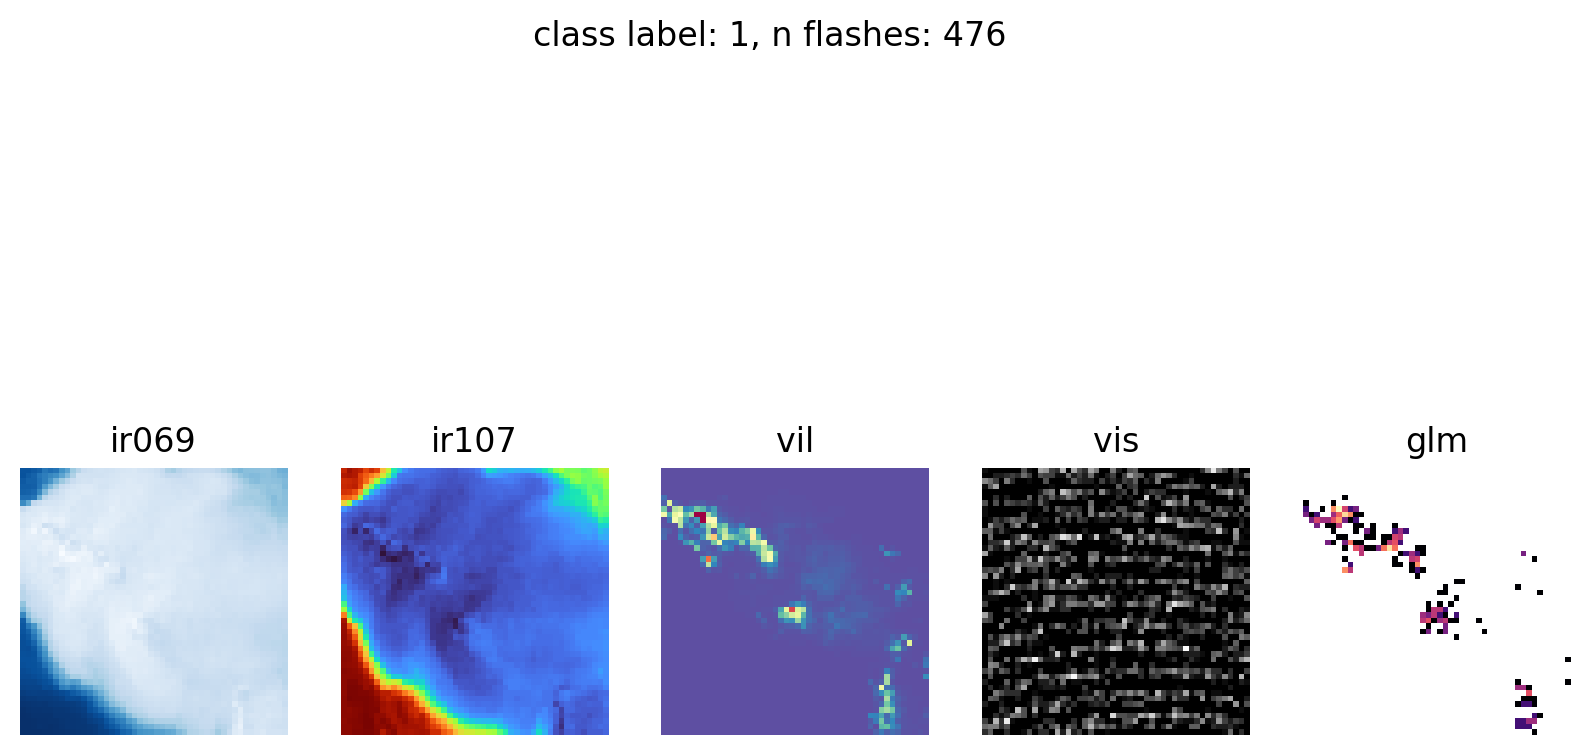

In [6]:
show_sample(ds_sample)

このサンプルの中心には深い対流雲が含まれています。可視画像が他の画像と異なって見えるのは夜の画像だからです。
このデータセットの場合、n_samples 次元に日時が格納されているので、画像の時刻が次のようにして確認できます。


In [7]:
ds_sample.n_samples

<xarray.DataArray 'n_samples' ()>
array('2018-07-12T01:05:00.000000000', dtype='datetime64[ns]')
Coordinates:
    id         <U15 'R18071205068701'
    n_samples  datetime64[ns] 2018-07-12T01:05:00

時間は UTC です。この場所では日没直後の時刻を表します。
表示を見ると id 次元に `R18071205068701` と出力されています。このファイルには同じイベントの 11 のタイムステップの画像が含まれます。
つまり、id を指定することで同じイベントに含まれる一連のタイムステップの画像が取得できます。

xarray の `groupby` メソッドを利用して同じ id を持つイベントのデータをすべて取得してみましょう。


In [8]:
def get_group_idx(group_string,ds):
    """id が group_string である画像のインデックスを取得する"""
    return ds.groupby('id').groups[group_string]

def get_groups(ds):
    """データセットに含まれるidのリストを取得する"""
    return list(ds.groupby('id').groups.keys())

In [9]:
storm_idx = get_group_idx(str(ds_sample.id.values), ds_train)
ds_sample_scene = ds_train.isel(n_samples=storm_idx)

ds_sample_scene

<xarray.Dataset>
Dimensions:         (n_samples: 12, x: 48, y: 48, n_channel: 4)
Coordinates:
    id              (n_samples) object 'R18071205068701' ... 'R18071205068701'
  * n_channel       (n_channel) <U5 'ir069' 'ir107' 'vil' 'vis'
  * n_samples       (n_samples) datetime64[ns] 2018-07-12T00:35:00 ... 2018-0...
Dimensions without coordinates: x, y
Data variables:
    features        (n_samples, x, y, n_channel) float32 ...
    label_1d_class  (n_samples) int8 ...
    label_1d_reg    (n_samples) int16 ...
    label_2d_class  (n_samples, x, y) int8 ...
    label_2d_reg    (n_samples, x, y) int16 ...

同じ id を持つデータは 12 個含まれていました。
12 個のデータを順に可視化してアニメーションを作成してみましょう。
次のコードを実行するとアニメーション gif を作成します。


In [14]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(10, 4))

ds = ds_sample_scene


def update(tt):
    plt.clf()

    ds_tmp = ds.isel(n_samples=tt)
    axes = fig.subplots(ncols=5)

    cmaps = ["Blues", "turbo", "Spectral_r", "Greys_r"]
    vmins = [-3, -2.25, 0, -1]
    vmaxs = [2, 2, 20, 2]
    for i, ax in enumerate(axes[0:4]):
        ax.imshow(ds_tmp.features[:, :, i], cmap=cmaps[i], vmin=vmins[i], vmax=vmaxs[i])
        ax.axis("off")
        ax.set_title(ds_tmp.n_channel[i].values)

    ax = axes[4]
    ax.imshow(np.log10(ds_tmp.label_2d_reg[:, :]), cmap="magma")
    ax.axis("off")
    ax.set_title("glm", fontsize=4)

    fig.suptitle(
        "class label: {}, n flashes: {}, time: {}".format(
            ds_tmp.label_1d_class.values,
            ds_tmp.label_1d_reg.values,
            ds_tmp.n_samples.dt.strftime("%Y-%m-%d %H:%M").values,
        ),
    )
    fig.tight_layout()


ani = animation.FuncAnimation(fig, update, 12, interval=100)
ani.save("../images/movie.gif", writer="pillow")
plt.close()

<img src="../images/movie.gif">


もっといろいろなシーンを選んで遊んでみてください。

次のノートではいよいよ機械学習に挑戦します。
